In [2]:
import pandas as pd
import geopandas as gpd
import rasterio
from cartopy import crs
from cartopy.io.img_tiles import MapboxTiles
from shapely.geometry import Point, mapping
from folium import GeoJson
from folium import Map
from numpy import mean
import geojson
import json

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (40,40)
token = 'pk.eyJ1IjoibWFwYm94IiwiYSI6ImNpejY4M29iazA2Z2gycXA4N2pmbDZmangifQ.-g_vE53SD2WrJ6tFX7QHmA'
%matplotlib inline
%config InlineBackend.figure_format = 'retina'


# Mt. Rainier Snow Cover Locations

from JHRL/Ian

In [3]:
snowcover = pd.read_csv("../data/snow_summary_all_2009_2017_locs.csv")
snowcover['geometry'] = [Point(xy) for xy in zip(snowcover.longitude, snowcover.latitude)]
snowcover = gpd.GeoDataFrame(snowcover)
snowcover.crs = {"init" : 'epsg:4326'}
bounds = snowcover.cascaded_union.buffer(0.01).bounds
bounds = [
    bounds[0],
    bounds[2],
    bounds[1],
    bounds[3]
]


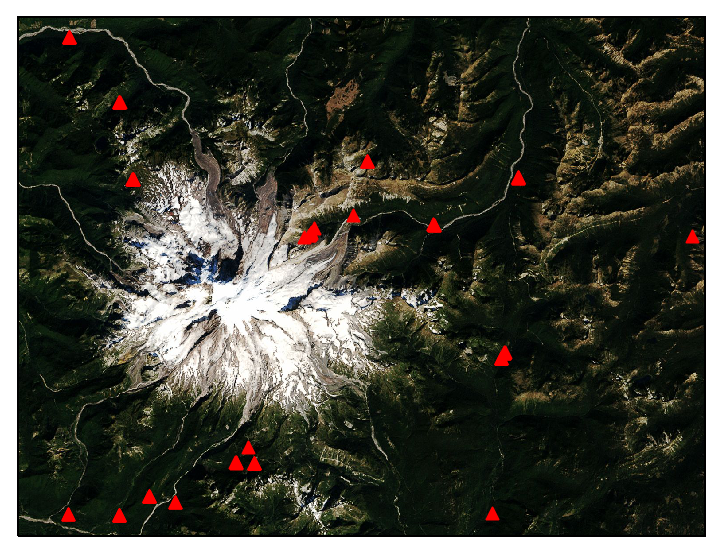

In [9]:
tiler = MapboxTiles(token, 'mapbox.satellite')
mercator = tiler.crs
ax = plt.axes(projection=mercator)
ax.set_extent(bounds)
thisyear = snowcover[snowcover.year == 2017].dropna()
#ax.add_geometries(snowcover.dropna().geometry.buffer(0.001), crs=crs.PlateCarree(), color='red')
ax.scatter([p.x for p in thisyear['geometry']], 
           [p.y for p in thisyear['geometry']], 
           transform=crs.PlateCarree(), marker="^", color='red')
ax.add_image(tiler, 12)
plt.tight_layout()
plt.savefig("testout.png", bbox_inches='tight', dpi=300)



In [66]:
!ls

20161022_181256_0e0e_3B_AnalyticMS_DN_udm_clip.tif
20161022_181256_0e0e_3B_AnalyticMS_clip.tif
20161022_181256_0e0e_3B_AnalyticMS_metadata_clip.xml
Untitled.ipynb
Untitled1.ipynb
Untitled2.ipynb
Untitled3.ipynb
data extract.ipynb
image_utils
locations.html
locations_map.csv
pipeline-all.ipynb
search-test.ipynb
sensor_bbox.json
testout.png


In [4]:
json = GeoJson(snowcover.dropna().to_json())
center = [mean(snowcover.latitude), mean(snowcover.longitude)]
m = Map(center)
json.add_to(m)
m.save('locations.html')

In [20]:
!du -h *

1.2M	locations.html
524K	Untitled.ipynb


In [5]:
unique = snowcover.drop_duplicates('Location').dropna()
small_json = GeoJson(unique.to_json())
center = [mean(unique.latitude), mean(unique.longitude)]
m = Map(center)
small_json.add_to(m)


In [5]:
gpd.casc

AttributeError: module 'geopandas' has no attribute 'casc'

In [6]:
coveredarea = unique.cascaded_union.convex_hull

In [7]:
geojson.Feature(geometry=coveredarea).geometry.coordinates

[[[-121.91632, 46.73899],
  [-121.91641000000001, 46.73915],
  [-121.91672, 46.739740000000005],
  [-121.88728, 46.994679999999995],
  [-121.53754920000002, 46.994992100000005],
  [-121.53741979999998, 46.99495506],
  [-121.5352794, 46.99410449],
  [-121.402, 46.888740000000006],
  [-121.55821, 46.741009999999996],
  [-121.91632, 46.73899]]]

In [8]:
!cat sensor_bbox.json

{"geometry": {"coordinates": [[[-121.91632, 46.73899], [-121.91641000000001, 46.73915], [-121.91672, 46.739740000000005], [-121.88728, 46.994679999999995], [-121.53754920000002, 46.994992100000005], [-121.53741979999998, 46.99495506], [-121.5352794, 46.99410449], [-121.402, 46.888740000000006], [-121.55821, 46.741009999999996], [-121.91632, 46.73899]]], "type": "Polygon"}, "properties": {}, "type": "Feature"}

In [9]:
geojson.Feature(geometry=coveredarea).geometry.coordinates

[[[-121.91632, 46.73899],
  [-121.91641000000001, 46.73915],
  [-121.91672, 46.739740000000005],
  [-121.88728, 46.994679999999995],
  [-121.53754920000002, 46.994992100000005],
  [-121.53741979999998, 46.99495506],
  [-121.5352794, 46.99410449],
  [-121.402, 46.888740000000006],
  [-121.55821, 46.741009999999996],
  [-121.91632, 46.73899]]]

,id,geometry
0,1,"POLYGON ((-121.91632 46.73899, -121.91641 46.7..."


In [35]:
?pd.DataFrame

In [25]:
from planet import api
aoi = {
    'type' : "Polygon",
    'coordinates' : geojson.Feature(geometry=coveredarea).geometry.coordinates

}
client = api.ClientV1()
query = api.filters.and_filter(
    api.filters.geom_filter(aoi), 
#    api.filters.date_range('acquired', gt="2018-01-"),
#    api.filters.date_range('acquired', lt="2018-01-20")
)
# we are requesting PlanetScope 4 Band imagery
item_types = ['SkySatScene']
request = api.filters.build_search_request(query, item_types)
# this will cause an exception if there are any API related errors
results = client.quick_search(request)
print (results.get_raw())

{"_links": {"_first": "https://api.planet.com/data/v1/searches/c56d2b63174342ee95f8cf02ac98fb83/results?_page=eyJxdWVyeV9wYXJhbXMiOiB7fSwgInNvcnRfcHJldiI6IGZhbHNlLCAicGFnZV9zaXplIjogMjUwLCAic29ydF9ieSI6ICJwdWJsaXNoZWQiLCAic29ydF9zdGFydCI6IG51bGwsICJzb3J0X2xhc3RfaWQiOiBudWxsLCAic29ydF9kZXNjIjogdHJ1ZX0%3D", "_next": null, "_self": "https://api.planet.com/data/v1/searches/c56d2b63174342ee95f8cf02ac98fb83/results?_page=eyJxdWVyeV9wYXJhbXMiOiB7fSwgInNvcnRfcHJldiI6IGZhbHNlLCAicGFnZV9zaXplIjogMjUwLCAic29ydF9ieSI6ICJwdWJsaXNoZWQiLCAic29ydF9zdGFydCI6IG51bGwsICJzb3J0X2xhc3RfaWQiOiBudWxsLCAic29ydF9kZXNjIjogdHJ1ZX0%3D"}, "features": [], "type": "FeatureCollection"}


In [17]:
for item in results.items_iter(10):
    print(item['id'], item['properties']['cloud_cover'], item['properties']['published'], item['_links']['thumbnail'])

In [221]:
from imp import reload
from image_utils import search
reload(search)
Search = search.Search

In [102]:
_gdf = gpd.GeoDataFrame(pd.DataFrame(data=['1'], columns=['id']), geometry=[coveredarea]).set_index('id')
_df = pd.DataFrame(columns=['id', 'start_date', 'end_date']).set_index('id')
_df = _df.append(pd.Series({
    'start_date' : pd.datetime(2018, 1, 20), 
    'end_date': pd.datetime(2018, 1, 22)
}, name='1'))
_df = _df.append(pd.Series({
    'start_date' : pd.datetime(2018, 1, 23), 
    'end_date': pd.datetime(2018, 1, 24)
}, name='1'))

results = Search(_gdf, _df).query()

0

In [146]:
m = Map(center)
GeoJson(mapping(coveredarea)).add_to(m)
small_json.add_to(m)
for _idx, date in enumerate(results):
    for scene in date:
        try:
            GeoJson(scene['geometry'], style_function=lambda f: {'color':'red'}).add_to(m)
        except Exception as e:
            print(e)
            continue
        
    

m

In [147]:
locations

NameError: name 'locations' is not defined

In [193]:
recent = snowcover[snowcover.year == 2017].dropna()
recent.geometry = [g.buffer(0.005, cap_style=3) for g in recent.geometry]
print(len(recent))
recent.head()
m = Map(center)
GeoJson(mapping(recent.geometry)).add_to(m)
m


83


In [246]:
reload(search)
Search = search.Search
_gdf = recent[['year', 'geometry']]
_df = pd.DataFrame([pd.Series({
    'start_date' : pd.datetime(2018,1,1),
    'end_date' : pd.datetime(2018,1,10)
}, name=i.name) for _, i in _gdf.iterrows()])
results = Search(_gdf, _df).query()


Querying Planet API:  11%|█         | 9/83 [00:07<01:03,  1.17searches/s]
Exception in thread Thread-6:
Traceback (most recent call last):
  File "/Users/tony/miniconda3/envs/imageprocess/lib/python3.5/threading.py", line 914, in _bootstrap_inner
    self.run()
  File "/Users/tony/miniconda3/envs/imageprocess/lib/python3.5/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/Users/tony/miniconda3/envs/imageprocess/lib/python3.5/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration

Querying Planet API: 100%|██████████| 83/83 [00:58<00:00,  1.43searches/s]


In [247]:
len(results)

83

In [248]:
m = Map(center)
GeoJson(mapping(recent.geometry)).add_to(m)

for _idx, (index,date) in enumerate(results):
    for scene in date:
        try:
            GeoJson(scene['geometry'], style_function=lambda f: {'color':'gray', 'opacity' : 0.2}).add_to(m)
            break;
        except Exception as e:
            print(e)
            continue
m